# Fit Spikes of HH with AdEx

In [1]:
from brian2 import *
from brian2modelfitting import *

INFO       Cache size for target "cython": 1006 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
tau = 0.1*ms

In [5]:
# The model
eqsHH = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 5*nA: amp

dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(2000*ms)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.26s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


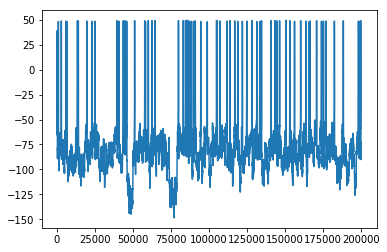

In [7]:
voltage = mon.v[0]/mV
plot(voltage);

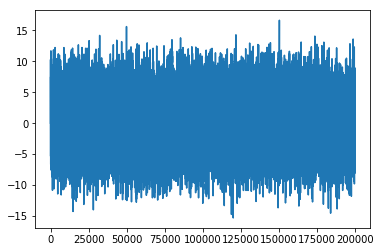

In [8]:
inp_cur = mon.I[0]/nA
plot(inp_cur);

In [9]:
out_spikes = [spike_mon.spike_trains()[0]/ms]
out_spikes

[array([1.75000e+00, 9.26000e+00, 2.87100e+01, 5.89900e+01, 6.63000e+01,
        1.34670e+02, 1.40420e+02, 1.97130e+02, 2.30430e+02, 2.50150e+02,
        3.94840e+02, 4.08060e+02, 4.35990e+02, 4.43780e+02, 4.52310e+02,
        4.58260e+02, 5.10420e+02, 5.76750e+02, 5.81550e+02, 6.00390e+02,
        6.24370e+02, 6.45340e+02, 7.98460e+02, 8.30210e+02, 8.45020e+02,
        8.54780e+02, 8.63540e+02, 8.72100e+02, 8.84600e+02, 9.00020e+02,
        9.08970e+02, 9.44780e+02, 9.87830e+02, 1.04890e+03, 1.05337e+03,
        1.07135e+03, 1.11689e+03, 1.13818e+03, 1.16811e+03, 1.18797e+03,
        1.21843e+03, 1.24714e+03, 1.28205e+03, 1.31290e+03, 1.33240e+03,
        1.34414e+03, 1.40758e+03, 1.43246e+03, 1.44509e+03, 1.46291e+03,
        1.50431e+03, 1.53008e+03, 1.56106e+03, 1.60138e+03, 1.63691e+03,
        1.65771e+03, 1.66354e+03, 1.70604e+03, 1.73815e+03, 1.75133e+03,
        1.76776e+03, 1.82309e+03, 1.88180e+03, 1.98113e+03, 1.98565e+03,
        1.99592e+03])]

## AdEx

In [10]:
start_scope()

In [200]:
# Parameters
C = 171 * pF
gL = 60 * nS
EL = -65 * mV
VT = -50.4 * mV
DeltaT = 5 * mV

tauw = 124*ms
a = 4*nS
b = 0.0805*nA
Vr = -70.6*mV # Regular spiking (as in the paper)

taum = C / gL
Vcut = VT + 50 * DeltaT


In [201]:
eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I(t) - w)/C : volt
dw/dt = (a*(vm - EL) - w)/tauw : amp
"""

In [202]:
I = TimedArray(inp_cur*nA, dt=dt)

In [203]:
neuron = NeuronGroup(1, model=eqs, threshold='vm>Vcut',
                     reset="vm=Vr; w+=b", method='exponential_euler')
neuron.vm = EL
trace = StateMonitor(neuron, 'vm', record=0)
spike_mon = SpikeMonitor(neuron)

In [204]:
run(30*ms)

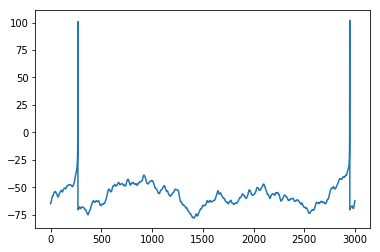

In [205]:
plot(trace.vm.transpose()/mV);